
Performance Metrics for S&P 500:
Sharpe Ratio (S&P 500): 0.6062135406788131
Sortino Ratio (S&P 500): 0.7377562229076915
Max Drawdown (S&P 500): 15.206271820448931

Percentage Returns for S&P 500:
S&P 500 Percentage Return: 138.3044413195916 %
XGBoost Model Accuracy: 0.9698996655518395

Performance Metrics for XGBoost:
Sharpe Ratio (XGBoost): 1.1041322455431322
Sortino Ratio (XGBoost): 1.2207242479773417
Max Drawdown (XGBoost): 0.7972615606026165

Percentage Returns for BTC and the XGBoost Strategy:
BTC Percentage Return: 181.7790209598667 %
XGBoost Strategy Percentage Return: 2995.4111600343213 %


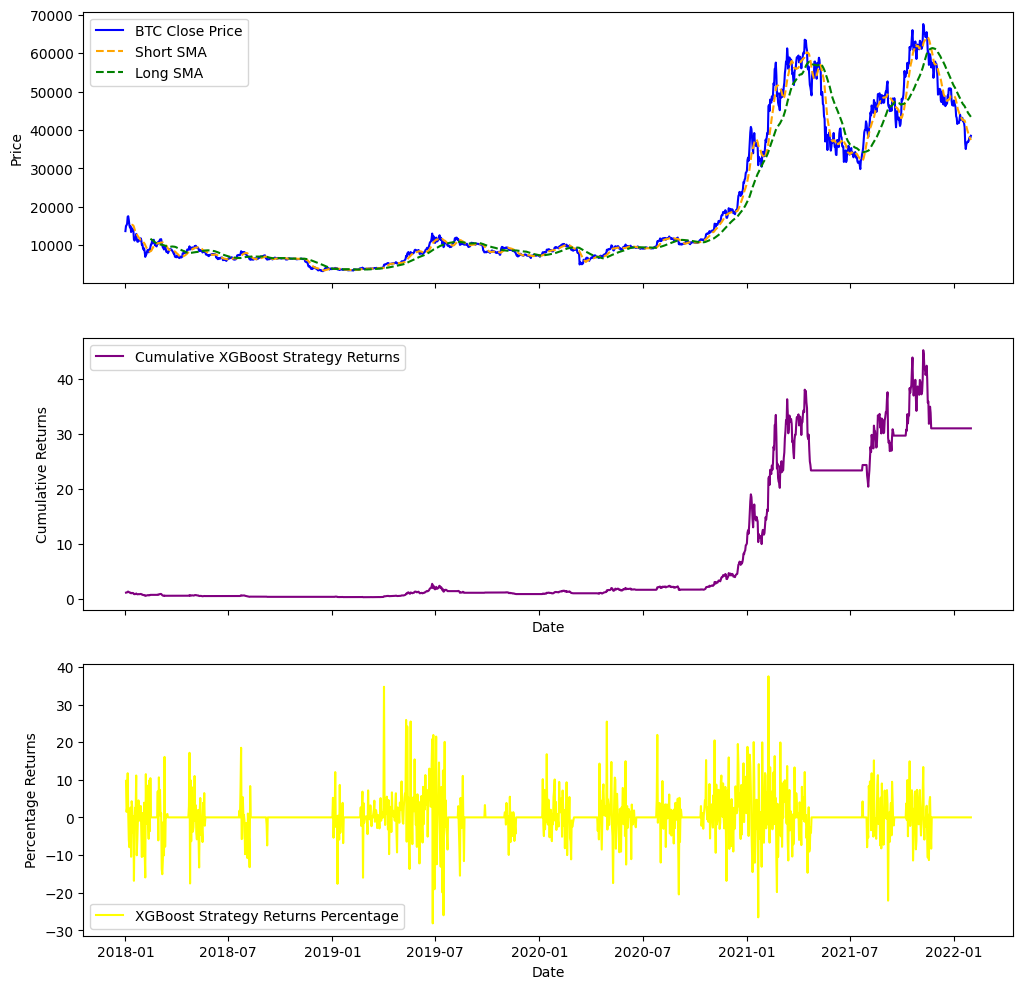

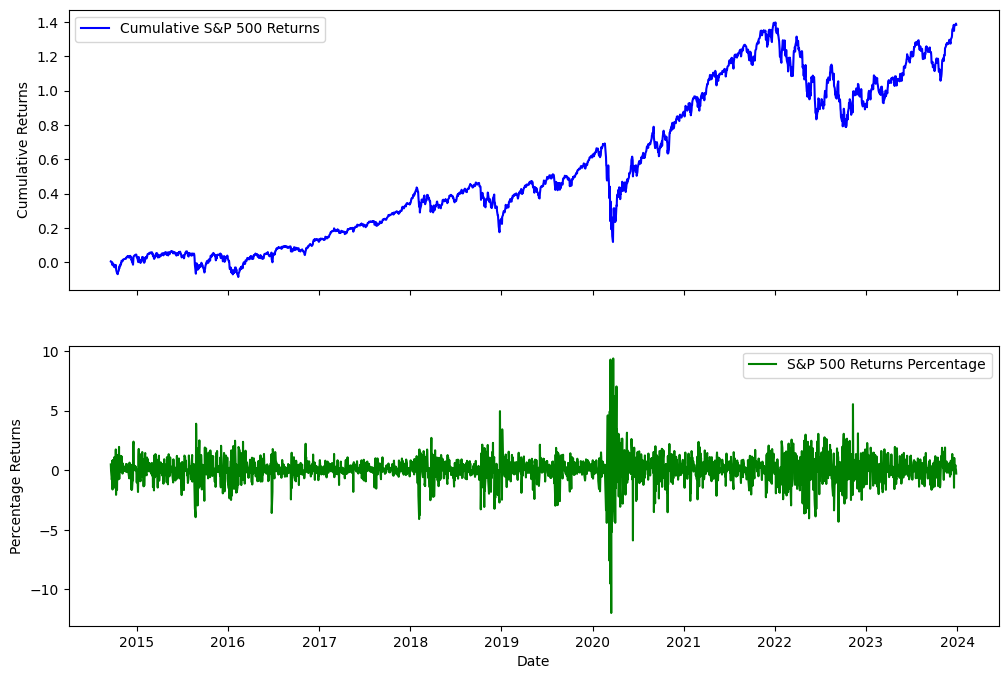

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Load BTC data
btc_data = pd.read_csv('BTC-USD2.csv')
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)
# btc_data = btc_data['2018':'2022-02-28']

# Load S&P 500 historical data

sp500_data = pd.read_csv('sp500_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate S&P 500 returns
sp500_data['sp500_returns_percentage'] = sp500_data['Adj Close'].pct_change() * 100

# Calculate cumulative S&P 500 returns
sp500_data['cumulative_sp500_returns'] = (1 + sp500_data['sp500_returns_percentage'] / 100).cumprod() - 1

# Calculate performance metrics for S&P 500
sp500_sharpe_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_sortino_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data[sp500_data['sp500_returns_percentage'] < 0]['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_max_drawdown = -(sp500_data['cumulative_sp500_returns'] / sp500_data['cumulative_sp500_returns'].cummax() - 1).min()

# Print performance metrics for S&P 500
print("\nPerformance Metrics for S&P 500:")
print("Sharpe Ratio (S&P 500):", sp500_sharpe_ratio)
print("Sortino Ratio (S&P 500):", sp500_sortino_ratio)
print("Max Drawdown (S&P 500):", sp500_max_drawdown)

# Print Percentage Returns for S&P 500
sp500_percentage_return = sp500_data['Adj Close'].iloc[-1] / sp500_data['Adj Close'].iloc[0] - 1
print("\nPercentage Returns for S&P 500:")
print("S&P 500 Percentage Return:", sp500_percentage_return*100,"%")

# Calculate additional indicators
btc_data['sma_short'] = btc_data['Close'].rolling(window=12).mean()
btc_data['sma_long'] = btc_data['Close'].rolling(window=45).mean()

# Generate signals based on moving average crossover
btc_data['buy_signal'] = np.where(btc_data['sma_short'] > btc_data['sma_long'], 1, 0)
btc_data['sell_signal'] = np.where(btc_data['sma_short'] < btc_data['sma_long'], -1, 0)
btc_data['position'] = btc_data['buy_signal'] + btc_data['sell_signal']

# Prepare features and target for machine learning model
features = btc_data[['sma_short', 'sma_long']]
target = btc_data['position']

# Convert target to [0, 1, 2]
target_classes = [-1, 0, 1]
btc_data['position'] = btc_data['position'].apply(lambda x: target_classes.index(x))

# Prepare features and target for machine learning model
features = btc_data[['sma_short', 'sma_long']]
target = btc_data['position']

# Impute NaN values in features
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Split data for machine learning model
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.2, random_state=42)

# Tune XGBoost hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,  # Number of classes
    n_estimators=7900,
    learning_rate=0.98,
    max_depth=11,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy}")

# Implement strategy based on XGBoost predictions
btc_data['xgb_signal'] = xgb_model.predict(features_imputed)

# Backtest the XGBoost strategy
btc_data['returns'] = btc_data['Close'].pct_change()
btc_data['xgb_strategy_returns'] = btc_data['xgb_signal'].shift(1) * btc_data['returns']
btc_data['cumulative_xgb_strategy_returns'] = (1 + btc_data['xgb_strategy_returns']).cumprod()

# Calculate performance metrics for XGBoost
xgb_sharpe_ratio = (btc_data['xgb_strategy_returns'].mean() / btc_data['xgb_strategy_returns'].std()) * np.sqrt(252)
xgb_sortino_ratio = (btc_data['xgb_strategy_returns'].mean() / btc_data[btc_data['xgb_strategy_returns'] < 0]['xgb_strategy_returns'].std()) * np.sqrt(252)
xgb_max_drawdown = -(btc_data['cumulative_xgb_strategy_returns'] / btc_data['cumulative_xgb_strategy_returns'].cummax() - 1).min()

# Print performance metrics for XGBoost
print("\nPerformance Metrics for XGBoost:")
print("Sharpe Ratio (XGBoost):", xgb_sharpe_ratio)
print("Sortino Ratio (XGBoost):", xgb_sortino_ratio)
print("Max Drawdown (XGBoost):", xgb_max_drawdown)

# Print Percentage Returns for BTC and the XGBoost Strategy
btc_percentage_return = btc_data['Close'].iloc[-1] / btc_data['Close'].iloc[0] - 1
xgb_strategy_percentage_return = btc_data['cumulative_xgb_strategy_returns'].iloc[-1] - 1

print("\nPercentage Returns for BTC and the XGBoost Strategy:")
print("BTC Percentage Return:", btc_percentage_return*100,"%")
print("XGBoost Strategy Percentage Return:", xgb_strategy_percentage_return*100,"%")

# Plot Results for BTC
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot BTC Close Price and SMAs
ax1.plot(btc_data.index, btc_data['Close'], label='BTC Close Price', color='blue')
ax1.plot(btc_data.index, btc_data['sma_short'], label='Short SMA', color='orange', linestyle='--')
ax1.plot(btc_data.index, btc_data['sma_long'], label='Long SMA', color='green', linestyle='--')
ax1.set_ylabel('Price')
ax1.legend()

# Plot Cumulative XGBoost Strategy Returns
ax2.plot(btc_data.index, btc_data['cumulative_xgb_strategy_returns'], label='Cumulative XGBoost Strategy Returns', color='purple')
ax2.set_ylabel('Cumulative Returns')
ax2.set_xlabel('Date')
ax2.legend()

# Plot Percentage Returns for XGBoost Strategy (Now in yellow)
ax3.plot(btc_data.index, btc_data['xgb_strategy_returns'] * 100, label='XGBoost Strategy Returns Percentage', color='yellow')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percentage Returns')
ax3.legend()

plt.show()

# Plot Results for S&P 500
fig2, (ax4, ax5) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Cumulative Returns for S&P 500
ax4.plot(sp500_data.index, sp500_data['cumulative_sp500_returns'], label='Cumulative S&P 500 Returns', color='blue')
ax4.set_ylabel('Cumulative Returns')
ax4.legend()

# Plot Percentage Returns for S&P 500
ax5.plot(sp500_data.index, sp500_data['sp500_returns_percentage'], label='S&P 500 Returns Percentage', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Percentage Returns')
ax5.legend()

plt.show()

In [4]:
# Calculate the requested metrics
gross_profit = btc_data[btc_data['xgb_strategy_returns'] > 0]['xgb_strategy_returns'].sum()
gross_loss = btc_data[btc_data['xgb_strategy_returns'] < 0]['xgb_strategy_returns'].sum()
net_profit = gross_profit + gross_loss
total_closed_trades = len(btc_data[btc_data['xgb_signal'] != 0])
win_rate = (len(btc_data[btc_data['xgb_strategy_returns'] > 0]) / total_closed_trades) * 100
max_drawdown = xgb_max_drawdown
average_winning_trade = gross_profit / len(btc_data[btc_data['xgb_strategy_returns'] > 0])
average_losing_trade = gross_loss / len(btc_data[btc_data['xgb_strategy_returns'] < 0])
buy_and_hold_return = btc_percentage_return * 100
largest_losing_trade = btc_data['xgb_strategy_returns'].min()
largest_winning_trade = btc_data['xgb_strategy_returns'].max()
sharpe_ratio = xgb_sharpe_ratio
sortino_ratio = xgb_sortino_ratio
btc_data['trade_duration'] = btc_data[btc_data['position'] != 0].groupby((btc_data['position'] != 0).cumsum()).cumcount() + 1
average_holding_duration_per_trade = btc_data[btc_data['position'] != 0]['trade_duration'].mean()
max_dip = btc_data['cumulative_xgb_strategy_returns'].max() - 1
average_dip = (btc_data['cumulative_xgb_strategy_returns'] - 1).mean()

# Print the calculated metrics
print("\nTrading Strategy Performance Metrics:")
print("Gross Profit:", gross_profit)
print("Net Profit:", net_profit)
print("Total Closed Trades:", total_closed_trades)
print("Win Rate (Profitability %):", win_rate)
print("Max Drawdown:", max_drawdown)
print("Gross Loss:", gross_loss)
print("Average Winning Trade (in USDT):", average_winning_trade)
print("Average Losing Trade (in USDT):", average_losing_trade)
print("Buy and Hold Return of BTC:", buy_and_hold_return)
print("Largest Losing Trade (in USDT):", largest_losing_trade)
print("Largest Winning Trade (in USDT):", largest_winning_trade)
print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)
print("Average Holding Duration per Trade:", average_holding_duration_per_trade)
print("Max Dip in Running Trade:", max_dip)
print("Average Dip in Running Trade:", average_dip)
btc_data


Trading Strategy Performance Metrics:
Gross Profit: 23.20237710285183
Net Profit: 5.5312826437567075
Total Closed Trades: 771
Win Rate (Profitability %): 54.215304798962386
Max Drawdown: 0.7972615606026165
Gross Loss: -17.671094459095123
Average Winning Trade (in USDT): 0.05550807919342543
Average Losing Trade (in USDT): -0.05005975767449043
Buy and Hold Return of BTC: 181.7790209598667
Largest Losing Trade (in USDT): -0.28171361453537824
Largest Winning Trade (in USDT): 0.3749294753587131
Sharpe Ratio: 1.1041322455431322
Sortino Ratio: 1.2207242479773417
Average Holding Duration per Trade: 1.0
Max Dip in Running Trade: 44.15681406220939
Average Dip in Running Trade: 7.1455385911106015


,Open,High,Low,Close,Adj Close,Volume,sma_short,sma_long,buy_signal,sell_signal,position,xgb_signal,returns,xgb_strategy_returns,cumulative_xgb_strategy_returns,trade_duration
Date,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,NaN,0,0,1,1,NaN,NaN,NaN,1.0
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,NaN,0,0,1,1,0.097011,0.097011,1.097011,1.0
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,NaN,NaN,0,0,1,1,0.014611,0.014611,1.113039,1.0
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,NaN,NaN,0,0,1,1,0.026196,0.026196,1.142196,1.0
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,NaN,NaN,0,0,1,1,0.117333,0.117333,1.276213,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629,38793.988932,44235.703125,0,-1,0,0,0.007764,0.000000,30.954112,NaN
2022-01-28,37128.445313,37952.878906,36211.109375,37784.332031,37784.332031,22238830523,38349.860026,44039.518663,0,-1,0,0,0.017397,0.000000,30.954112,NaN
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,38138.179688,17194183075,38007.162435,43800.439931,0,-1,0,0,0.009365,0.000000,30.954112,NaN
